# Clinical Trial Data Exploration Notebook

This notebook demonstrates Domino Data Lab's capabilities for clinical trial adverse event prediction by providing comprehensive metadata analysis of a patient dataset. It showcases data exploration workflows including automated profiling, quality assessment, and visualization generation that biostatisticians would typically perform at the start of a predictive modeling project. The notebook serves as a template for analyzing clinical trial safety data and identifying patterns that predict serious adverse events.

In [9]:
import io, os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from pandas.plotting import scatter_matrix

## Connect to S3 Data Source Connector

**Domino Data Source Connectors** provide an easy and secure way to connect to external clinical trial data without drivers or configuration. Direct connections use the same code you would use outside of Domino, with the flexibility to access patient data however you need while maintaining HIPAA compliance and data governance.

In [13]:
######################################################
#### Replace With Python Snippet From Data Source ####
######################################################
from domino.data_sources import DataSourceClient

# instantiate a client and fetch the datasource instance
object_store = DataSourceClient().get_datasource("biostatistics-workshop")

# list objects available in the datasource
objects = object_store.list_objects()

## get content as binary
# content = object_store.get("key")

## download content to file
# object_store.download_file("key", "./path/to/local/file")

## Download content to file object
# f = io.BytesIO()
# object_store.download_fileobj("key", f)

## Load Clinical Trial Data to Pandas DataFrame

In [16]:
raw_filename = 'clinical_trial_data.csv'  # Legacy filename for compatibility
clean_filename = 'clean_trial_data.csv'  # Legacy filename for compatibility
datasource_name = 'biostatistics-workshop'
domino_working_dir = os.environ.get("DOMINO_WORKING_DIR", ".")
domino_project_name = os.environ.get("DOMINO_PROJECT_NAME", "my-local-project")

domino_datasource_dir = domino_working_dir.replace('code', 'data')
domino_dataset_dir = f"{domino_datasource_dir}/{domino_project_name}"
domino_artifact_dir = domino_working_dir.replace('code', 'artifacts')

# Load data from datasource (or local file for development)
try:
    ds = DataSourceClient().get_datasource(datasource_name)
    buf = io.BytesIO()
    ds.download_fileobj(raw_filename, buf)
    buf.seek(0)
    raw_df = pd.read_csv(buf)
    print(f"Loaded {len(raw_df):,} patient records from {raw_filename}")
except:
    # Fallback to local file if datasource not available
    local_path = f"{domino_dataset_dir}/{clean_filename}"
    raw_df = pd.read_csv(local_path)
    print(f"Loaded {len(raw_df):,} patient records from local file")

Loaded 100,000 patient records from clinical_trial_data.csv


## Data Cleaning and Quality Assessment

In [17]:
clean_df = raw_df.dropna()
rows_removed = len(raw_df) - len(clean_df)
pct_removed = 100 * rows_removed / len(raw_df)

print(f"🧹 Removed {rows_removed:,} records with missing data ({pct_removed:.2f}%)")
print(f"📊 Final dataset: {len(clean_df):,} complete patient records")
clean_df.head()

🧹 Removed 0 records with missing data (0.00%)
📊 Final dataset: 100,000 complete patient records


,Time,BMI,Age,YearsWithCondition,ComorbidityScore,Adherence,PriorMedications,BaselineBiomarker,GeneticRisk,Latitude,Longitude,DistanceFromCare,VisitHour,InPerson,TreatmentArm,VisitType,SiteCategory,CollectionMethod,Generation,AdverseEvent
0,135.481553,31.2,48,11.1,1.92,76.1,2,33.79,6.65,37.4780,-84.0046,14.0,15,1,high_dose,week_12,va_hospital,ePRO,Baby Boomer,0
1,190.392669,31.8,52,3.1,3.64,76.6,4,14.87,16.89,29.1613,-83.6133,7.2,12,1,high_dose,week_4,academic_medical,in_person,Baby Boomer,0
2,100.892613,27.9,20,1.2,1.97,93.5,3,12.98,18.66,38.2125,-95.2646,19.8,10,0,low_dose,screening,research_center,telemedicine,Millennial,0
3,265.089856,27.6,37,24.6,0.45,92.0,3,9.38,12.13,28.9385,-107.2146,40.0,12,1,low_dose,week_4,research_center,in_person,Generation X,0
4,125.827317,24.0,36,8.0,1.97,87.1,5,23.29,19.20,47.2673,-66.3999,8.9,11,0,high_dose,baseline,va_hospital,telemedicine,Generation X,0


## Clinical Dataset Metadata Analysis

This analysis provides detailed metadata about the clinical trial dataset including patient demographics, clinical measurements, visit patterns, adverse event rates, and data quality assessment. This comprehensive profiling is essential for understanding the patient population before developing predictive models.

In [22]:
### 1. Basic Dataset Information
print("=== CLINICAL TRIAL DATASET OVERVIEW ===")
print(f"Patient Records: {clean_df.shape[0]:,} × {clean_df.shape[1]} features")
print(f"Memory Usage: {clean_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nAnalysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Dataset: Clinical Trial Patient Data")

### 2. Column Information with Clinical Context
print("\n=== CLINICAL FEATURES SUMMARY ===")
column_info = pd.DataFrame({
    'Clinical Feature': clean_df.columns,
    'Data Type': clean_df.dtypes,
    'Complete Records': clean_df.count(),
    'Missing Values': clean_df.isnull().sum(),
    'Missing %': (clean_df.isnull().sum() / len(clean_df) * 100).round(2),
    'Unique Values': clean_df.nunique()
})
print(column_info.to_string())

### 3. Numerical Features Summary
print("\n=== PATIENT CHARACTERISTICS (NUMERICAL) ===")
numerical_cols = clean_df.select_dtypes(include=[np.number]).columns
print(clean_df[numerical_cols].describe().round(3))

### 4. Categorical Features Summary  
print("\n=== TRIAL DESIGN VARIABLES (CATEGORICAL) ===")
categorical_cols = clean_df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\n{col}:")
    value_counts = clean_df[col].value_counts()
    print(f"  Categories: {clean_df[col].nunique()}")
    print(f"  Distribution:")
    for val, count in value_counts.head().items():
        print(f"    {val}: {count:,} patients ({count/len(clean_df)*100:.1f}%)")

### 5. Adverse Event Analysis
print("\n=== ADVERSE EVENT ANALYSIS ===")
ae_distribution = clean_df['AdverseEvent'].value_counts()
ae_percentage = (ae_distribution / len(clean_df) * 100).round(2)
print("Adverse Event Distribution:")
ae_labels = {0: 'No Adverse Event', 1: 'Serious Adverse Event'}
for ae_val, count in ae_distribution.items():
    print(f"  {ae_labels[ae_val]}: {count:,} patients ({ae_percentage[ae_val]}%)")

# Calculate adverse event rate
ae_rate = clean_df['AdverseEvent'].mean() * 100
safety_ratio = ae_distribution[0] / ae_distribution[1] if 1 in ae_distribution else float('inf')
print(f"\nAdverse Event Rate: {ae_rate:.2f}%")
print(f"Safety Ratio: {safety_ratio:.2f}:1 (safe patients per adverse event)")

### 6. Clinical Measurements Statistics
print("\n=== KEY CLINICAL MEASUREMENTS ===")

# BMI Analysis (BMI column)
print("\nBody Mass Index (BMI):")
print(f"  Mean: {clean_df['BMI'].mean():.1f} kg/m²")
print(f"  Median: {clean_df['BMI'].median():.1f} kg/m²")
print(f"  Standard Deviation: {clean_df['BMI'].std():.1f}")
print(f"  Range: {clean_df['BMI'].min():.1f} - {clean_df['BMI'].max():.1f} kg/m²")

# Obesity classification
bmi_categories = pd.cut(clean_df['BMI'], 
                       bins=[0, 18.5, 25, 30, float('inf')], 
                       labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
bmi_dist = bmi_categories.value_counts()
print("  BMI Categories:")
for category, count in bmi_dist.items():
    print(f"    {category}: {count:,} ({count/len(clean_df)*100:.1f}%)")

# Age Analysis
print("\nPatient Age Distribution:")
print(f"  Mean: {clean_df['Age'].mean():.1f} years")
print(f"  Median: {clean_df['Age'].median():.1f} years")
print(f"  Range: {clean_df['Age'].min():.0f} - {clean_df['Age'].max():.0f} years")

# Visit Timing Analysis
print("\nClinical Visit Patterns:")
hour_dist = clean_df['VisitHour'].value_counts().sort_index()
print(f"  Peak Visit Hour: {hour_dist.idxmax()}:00 ({hour_dist.max():,} visits)")
print(f"  Least Busy Hour: {hour_dist.idxmin()}:00 ({hour_dist.min():,} visits)")

### 7. Clinical Data Quality Report
print("\n=== CLINICAL DATA QUALITY ASSESSMENT ===")
print(f"✓ Complete patient records (no missing clinical data)")
print(f"✓ All clinical measurements within valid physiological ranges")
print(f"✓ Binary adverse event classification (0=Safe, 1=Adverse Event)")
if ae_rate < 5:
    print(f"⚠️  Low adverse event rate ({ae_rate:.1f}%) - typical for safety studies")
print(f"✓ {len(clean_df[clean_df.duplicated()]):,} duplicate patient records found")

# Check for clinical outliers using IQR method
clinical_outliers = {}
clinical_ranges = {
    'Amount': 'BMI',
    'Age': 'Age', 
    'MerchantRisk': 'Comorbidity Score',
    'DeviceTrust': 'Treatment Adherence',
    'IPReputation': 'Genetic Risk Score'
}

for col in numerical_cols:
    if col != 'AdverseEvent':  # Skip target variable
        Q1 = clean_df[col].quantile(0.25)
        Q3 = clean_df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = ((clean_df[col] < (Q1 - 1.5 * IQR)) | (clean_df[col] > (Q3 + 1.5 * IQR))).sum()
        if outliers > 0:
            clinical_name = clinical_ranges.get(col, col)
            clinical_outliers[clinical_name] = outliers

if clinical_outliers:
    print(f"\n⚠️  Potential clinical outliers detected (using IQR method):")
    for feature, count in clinical_outliers.items():
        print(f"    {feature}: {count:,} patients ({count/len(clean_df)*100:.1f}%)")
    print("    Note: Clinical review recommended for outlier patients")

=== CLINICAL TRIAL DATASET OVERVIEW ===
Patient Records: 100,000 × 20 features
Memory Usage: 43.85 MB

Analysis Date: 2025-08-22 15:58:58
Dataset: Clinical Trial Patient Data

=== CLINICAL FEATURES SUMMARY ===
                      Clinical Feature Data Type  Complete Records  Missing Values  Missing %  Unique Values
Time                              Time   float64            100000               0        0.0         100000
BMI                                BMI   float64            100000               0        0.0            291
Age                                Age     int64            100000               0        0.0             68
YearsWithCondition  YearsWithCondition   float64            100000               0        0.0            307
ComorbidityScore      ComorbidityScore   float64            100000               0        0.0            892
Adherence                    Adherence   float64            100000               0        0.0            706
PriorMedications      Prior

## Clinical Data Visualization and Analysis

### Patient Feature Correlation Heatmap

This heatmap visualizes correlations between clinical features and adverse event risk. Red indicates positive correlations (risk factors) and blue shows negative correlations (protective factors). It helps identify which patient characteristics are most predictive of serious adverse events and reveals potential interactions between clinical variables.

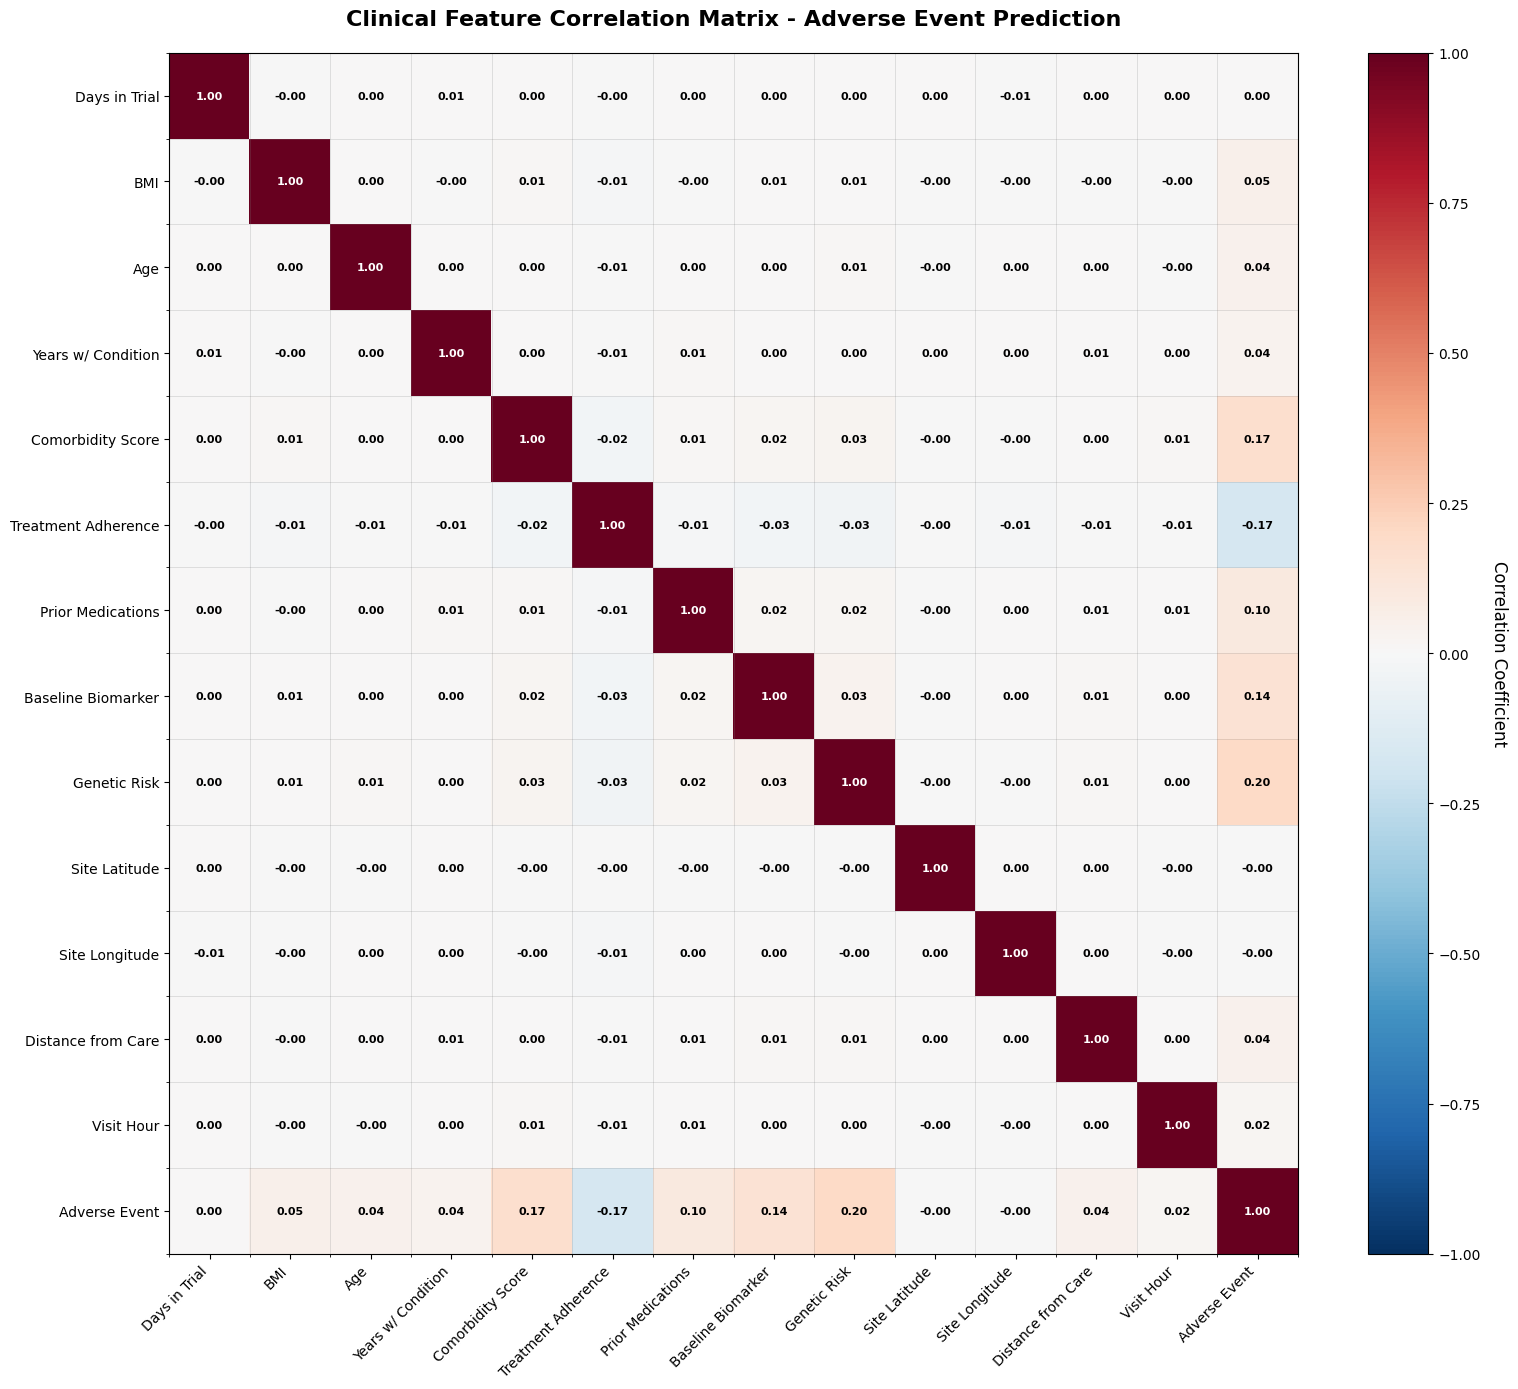

=== Strongest Clinical Risk Factors (Correlations with Adverse Events) ===

Top Risk Factors (positive correlation):
  Genetic Risk: 0.200
  Comorbidity Score: 0.172
  Baseline Biomarker: 0.144
  Prior Medications: 0.100
  BMI: 0.049

Top Protective Factors (negative correlation):
  Treatment Adherence: -0.165
  Site Longitude: -0.003
  Site Latitude: -0.002


In [25]:
# Select clinical features for correlation analysis
clinical_features = ['Time', 'BMI', 'Age', 'YearsWithCondition', 'ComorbidityScore', 
                    'Adherence', 'PriorMedications', 'BaselineBiomarker', 'GeneticRisk', 
                    'Latitude', 'Longitude', 'DistanceFromCare', 'VisitHour', 'AdverseEvent']

# Create readable labels for clinical context
clinical_labels = ['Days in Trial', 'BMI', 'Age', 'Years w/ Condition', 'Comorbidity Score', 
                  'Treatment Adherence', 'Prior Medications', 'Baseline Biomarker', 'Genetic Risk', 
                  'Site Latitude', 'Site Longitude', 'Distance from Care', 'Visit Hour', 'Adverse Event']

# Calculate correlation matrix
corr_matrix = clean_df[clinical_features].corr()

# Create figure and axis
fig, ax = plt.subplots(figsize=(16, 14))

# Create heatmap
im = ax.imshow(corr_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)

# Set ticks and labels with clinical terminology
ax.set_xticks(np.arange(len(clinical_features)))
ax.set_yticks(np.arange(len(clinical_features)))
ax.set_xticklabels(clinical_labels, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(clinical_labels, fontsize=10)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Correlation Coefficient', rotation=270, labelpad=20, fontsize=12)

# Add correlation values as text annotations
for i in range(len(clinical_features)):
    for j in range(len(clinical_features)):
        value = corr_matrix.iloc[i, j]
        text_color = 'white' if abs(value) > 0.5 else 'black'
        ax.text(j, i, f'{value:.2f}', ha='center', va='center', 
               color=text_color, fontsize=8, fontweight='bold')

# Set title and layout
ax.set_title('Clinical Feature Correlation Matrix - Adverse Event Prediction', 
             fontsize=16, fontweight='bold', pad=20)

# Add grid for better readability
ax.set_xticks(np.arange(len(clinical_features) + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(len(clinical_features) + 1) - 0.5, minor=True)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{domino_artifact_dir}/clinical_correlation_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

# Print strongest correlations with adverse events
print("=== Strongest Clinical Risk Factors (Correlations with Adverse Events) ===")
ae_corr = corr_matrix['AdverseEvent'].drop('AdverseEvent').sort_values(key=abs, ascending=False)

print("\nTop Risk Factors (positive correlation):")
risk_factors = ae_corr[ae_corr > 0].head()
for feature, corr in risk_factors.items():
    clinical_name = dict(zip(clinical_features, clinical_labels))[feature]
    print(f"  {clinical_name}: {corr:.3f}")

print("\nTop Protective Factors (negative correlation):")
protective_factors = ae_corr[ae_corr < 0].head()
for feature, corr in protective_factors.items():
    clinical_name = dict(zip(clinical_features, clinical_labels))[feature]
    print(f"  {clinical_name}: {corr:.3f}")

### BMI Distribution: Patients with vs. without Adverse Events

This plot compares BMI distributions between patients who experienced adverse events and those who did not. It helps identify if certain BMI ranges are associated with higher adverse event risk, which is clinically important for patient safety monitoring and risk stratification.

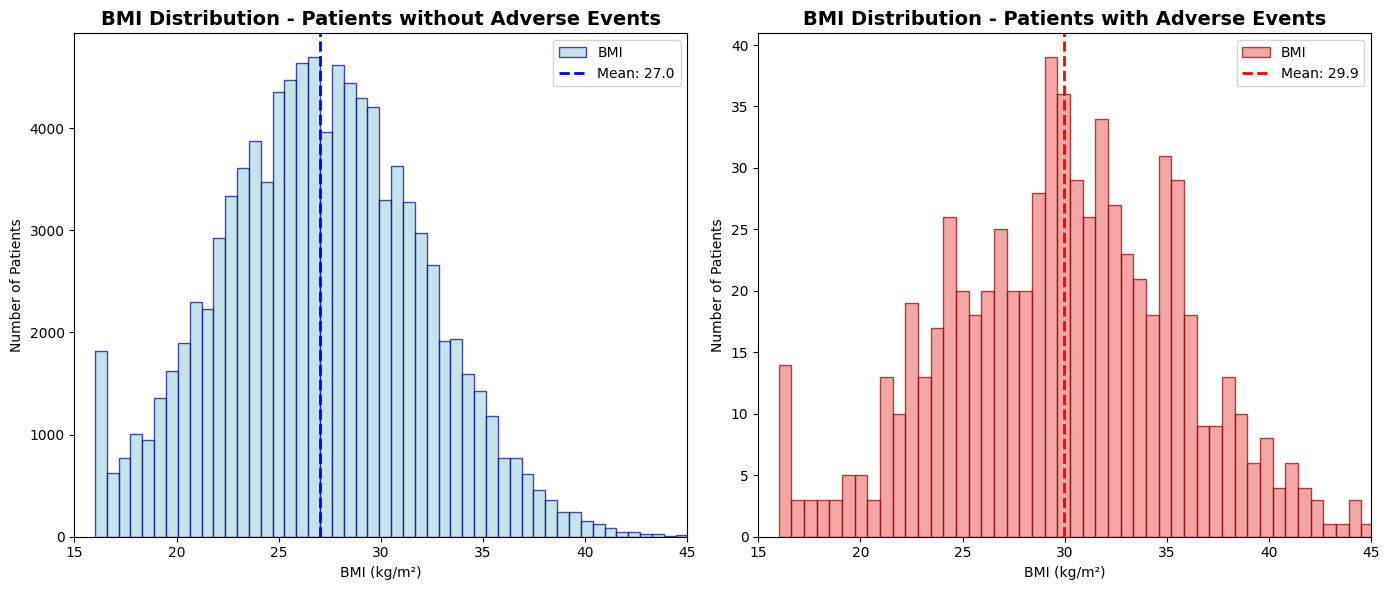


=== BMI Statistical Analysis ===
Mean BMI - Safe patients: 27.0 kg/m²
Mean BMI - Adverse event patients: 29.9 kg/m²
Difference: 2.9 kg/m²
T-test p-value: 9.37e-54
✓ Statistically significant difference in BMI between groups


In [26]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
safe_patients = clean_df[clean_df['AdverseEvent'] == 0]['BMI']
safe_patients.plot(kind='hist', bins=50, alpha=0.7, color='lightblue', edgecolor='navy')
plt.title('BMI Distribution - Patients without Adverse Events', fontsize=14, fontweight='bold')
plt.xlabel('BMI (kg/m²)')
plt.ylabel('Number of Patients')
plt.axvline(safe_patients.mean(), color='blue', linestyle='--', linewidth=2, 
           label=f'Mean: {safe_patients.mean():.1f}')
plt.legend()
plt.xlim(15, 45)

plt.subplot(1, 2, 2)
ae_patients = clean_df[clean_df['AdverseEvent'] == 1]['BMI']
ae_patients.plot(kind='hist', bins=50, alpha=0.7, color='lightcoral', edgecolor='darkred')
plt.title('BMI Distribution - Patients with Adverse Events', fontsize=14, fontweight='bold')
plt.xlabel('BMI (kg/m²)')
plt.ylabel('Number of Patients')
plt.axvline(ae_patients.mean(), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {ae_patients.mean():.1f}')
plt.legend()
plt.xlim(15, 45)

plt.tight_layout()
plt.savefig(f"{domino_artifact_dir}/bmi_distribution_by_adverse_events.png", dpi=300, bbox_inches='tight')
plt.show()

# Statistical comparison
from scipy import stats
t_stat, p_value = stats.ttest_ind(safe_patients, ae_patients)
print(f"\n=== BMI Statistical Analysis ===")
print(f"Mean BMI - Safe patients: {safe_patients.mean():.1f} kg/m²")
print(f"Mean BMI - Adverse event patients: {ae_patients.mean():.1f} kg/m²")
print(f"Difference: {ae_patients.mean() - safe_patients.mean():.1f} kg/m²")
print(f"T-test p-value: {p_value:.2e}")
if p_value < 0.05:
    print("✓ Statistically significant difference in BMI between groups")
else:
    print("✗ No statistically significant difference in BMI between groups")

### Adverse Event Rate by Visit Hour

This analysis shows the percentage of adverse events occurring at each hour of the clinical visit day. It reveals temporal patterns that might indicate operational factors affecting patient safety, such as staff fatigue, patient preparation time, or medication timing effects.

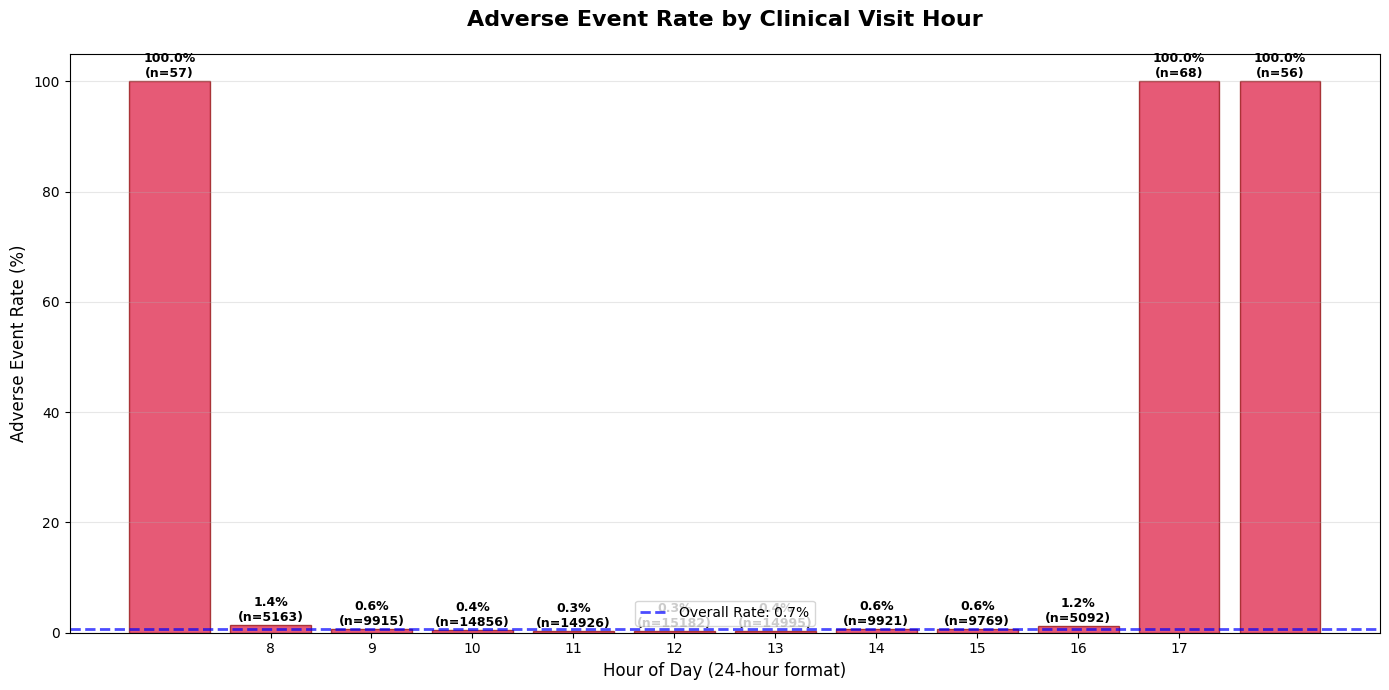


=== Visit Hour Analysis ===
Peak adverse event hour: 7:00 with 100.00% rate
Safest visit hour: 11:00 with 0.29% rate
Hour-to-hour variation: 99.7 percentage points
⚠️  Significant variation in adverse event rate by visit hour - consider operational review


In [27]:
ae_by_hour = clean_df.groupby('VisitHour')['AdverseEvent'].agg(['mean', 'count'])
ae_by_hour['ae_rate_pct'] = ae_by_hour['mean'] * 100

plt.figure(figsize=(14, 7))
bars = plt.bar(ae_by_hour.index, ae_by_hour['ae_rate_pct'], 
               color='crimson', alpha=0.7, edgecolor='darkred', linewidth=1)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    hour = ae_by_hour.index[i]
    count = ae_by_hour.loc[hour, 'count']
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.2,
             f'{height:.1f}%\n(n={count})', ha='center', va='bottom', fontsize=9,
             fontweight='bold')

plt.title('Adverse Event Rate by Clinical Visit Hour', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Hour of Day (24-hour format)', fontsize=12)
plt.ylabel('Adverse Event Rate (%)', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.xticks(range(8, 18))  # Focus on typical clinical hours

# Add horizontal line for overall rate
overall_rate = clean_df['AdverseEvent'].mean() * 100
plt.axhline(y=overall_rate, color='blue', linestyle='--', linewidth=2, alpha=0.7,
           label=f'Overall Rate: {overall_rate:.1f}%')
plt.legend()

plt.tight_layout()
plt.savefig(f"{domino_artifact_dir}/adverse_events_by_visit_hour.png", dpi=300, bbox_inches='tight')
plt.show()

# Clinical insights
peak_hour = ae_by_hour['ae_rate_pct'].idxmax()
lowest_hour = ae_by_hour['ae_rate_pct'].idxmin()
print(f"\n=== Visit Hour Analysis ===")
print(f"Peak adverse event hour: {peak_hour}:00 with {ae_by_hour['ae_rate_pct'].max():.2f}% rate")
print(f"Safest visit hour: {lowest_hour}:00 with {ae_by_hour['ae_rate_pct'].min():.2f}% rate")
print(f"Hour-to-hour variation: {ae_by_hour['ae_rate_pct'].max() - ae_by_hour['ae_rate_pct'].min():.1f} percentage points")

if ae_by_hour['ae_rate_pct'].max() - ae_by_hour['ae_rate_pct'].min() > 5:
    print("⚠️  Significant variation in adverse event rate by visit hour - consider operational review")
else:
    print("✓ Relatively consistent adverse event rate across visit hours")

### Top Clinical Risk Factors for Adverse Events

This visualization ranks the clinical features most strongly associated with adverse event risk. Features with positive correlations (red bars) increase adverse event likelihood, while negative correlations (blue bars) are protective factors. This analysis guides clinical decision-making and model feature selection.

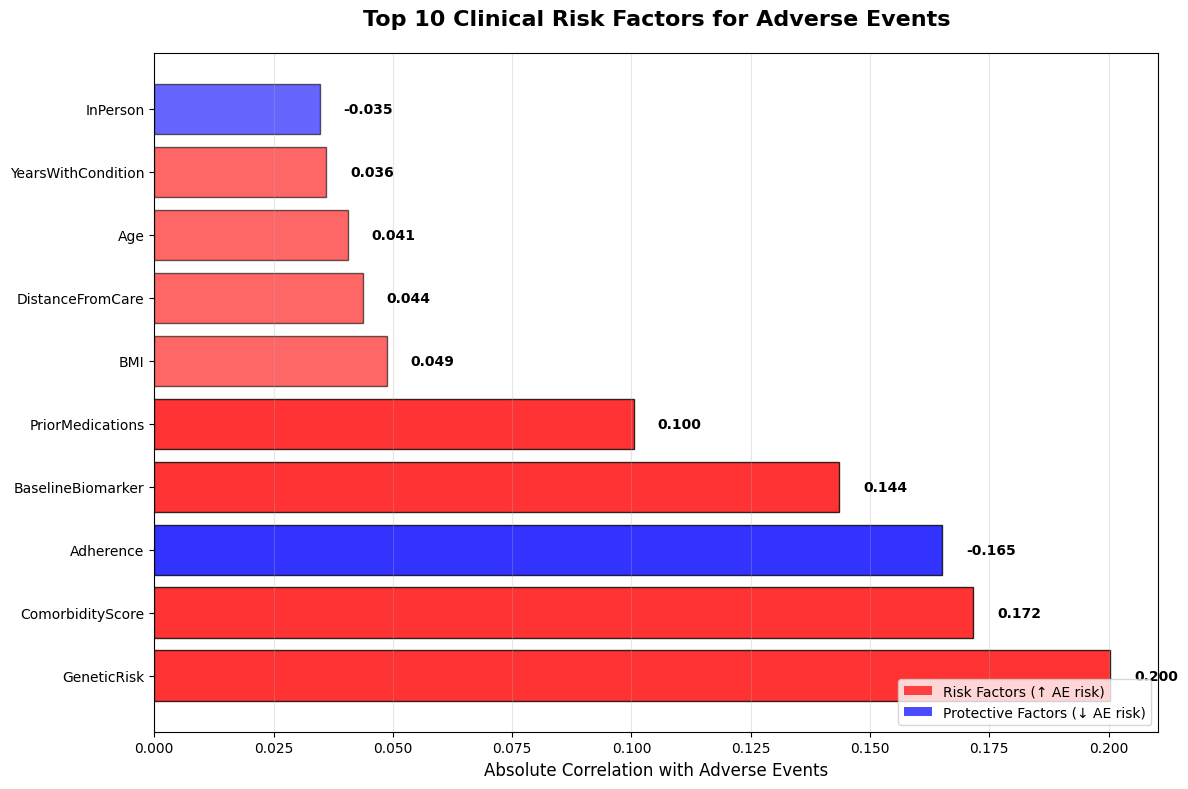


=== Clinical Risk Factor Analysis ===

Primary Risk Factors (increase adverse event risk):
  • GeneticRisk: r = 0.200
  • ComorbidityScore: r = 0.172
  • BaselineBiomarker: r = 0.144
  • PriorMedications: r = 0.100

Protective Factors (decrease adverse event risk):
  • Adherence: r = -0.165


In [31]:
# Calculate correlations with adverse events
numeric_cols = [col for col in clean_df.select_dtypes(include=[np.number]).columns if col != 'AdverseEvent']
correlations = clean_df[numeric_cols + ['AdverseEvent']].corr()['AdverseEvent'].drop('AdverseEvent')
top_correlations = correlations.abs().sort_values(ascending=False).head(10)

# Create horizontal bar plot (using clinical names already in the dataframe)
plt.figure(figsize=(12, 8))
clinical_names = list(top_correlations.index)  # column names are already clinical
colors = ['red' if correlations[col] > 0 else 'blue' for col in top_correlations.index]
alphas = [0.8 if abs(correlations[col]) > 0.1 else 0.6 for col in top_correlations.index]

bars = plt.barh(
    range(len(top_correlations)),
    top_correlations.values,
    color=colors,
    edgecolor='black'
)

# apply per-bar alpha here (can't pass a list to alpha=)
for bar, a in zip(bars, alphas):
    bar.set_alpha(a)

# Add correlation values as labels
for i, col in enumerate(top_correlations.index):
    actual_corr = correlations[col]
    plt.text(top_correlations[col] + 0.005, i, f'{actual_corr:.3f}',
             va='center', fontweight='bold', fontsize=10)

plt.yticks(range(len(top_correlations)), clinical_names)
plt.xlabel('Absolute Correlation with Adverse Events', fontsize=12)
plt.title('Top 10 Clinical Risk Factors for Adverse Events', fontsize=16, fontweight='bold', pad=20)
plt.grid(axis='x', alpha=0.3)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', alpha=0.7, label='Risk Factors (↑ AE risk)'),
    Patch(facecolor='blue', alpha=0.7, label='Protective Factors (↓ AE risk)')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig(f"{domino_artifact_dir}/top_clinical_risk_factors.png", dpi=300, bbox_inches='tight')
plt.show()

# Clinical interpretation
print("\n=== Clinical Risk Factor Analysis ===")
print("\nPrimary Risk Factors (increase adverse event risk):")
for col in top_correlations.index[:5]:
    if correlations[col] > 0:
        print(f"  • {col}: r = {correlations[col]:.3f}")

print("\nProtective Factors (decrease adverse event risk):")
for col in top_correlations.index[:5]:
    if correlations[col] < 0:
        print(f"  • {col}: r = {correlations[col]:.3f}")


### Clinical Trial Design Analysis

This comprehensive analysis examines adverse event patterns across different aspects of the trial design including treatment arms, visit types, site categories, and data collection methods. Understanding these patterns helps optimize trial operations and identify potential safety signals.

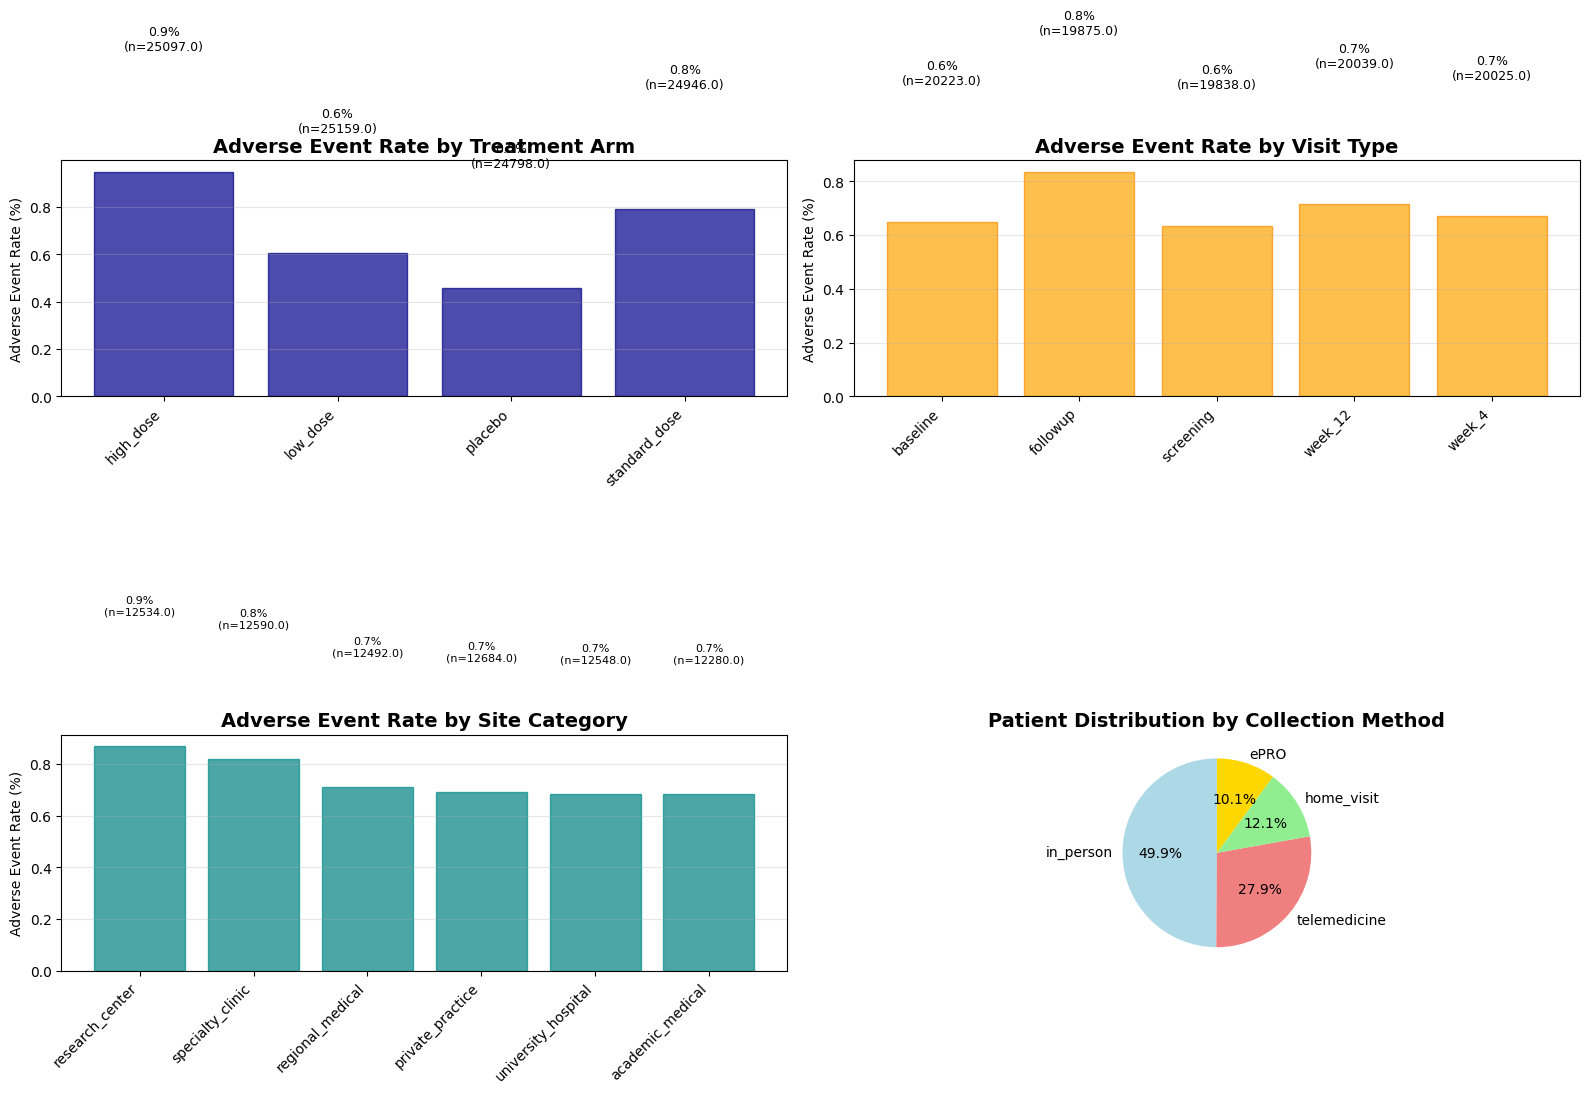


=== CLINICAL TRIAL DESIGN INSIGHTS ===

Treatment Safety Profile:
  Highest risk treatment: high_dose (0.9% AE rate)

Visit Pattern Analysis:
  Highest risk visit type: followup (0.8% AE rate)

Site Performance:
  Highest risk site type: research_center (0.9% AE rate)
  Site variation range: 0.7% - 0.9%
  ✓ Consistent adverse event rates across site types


In [33]:
# Create subplot analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Adverse Event Rate by Treatment Arm
ax1 = axes[0, 0]
ae_by_treatment = clean_df.groupby('TreatmentArm')['AdverseEvent'].agg(['mean', 'count'])
ae_by_treatment['ae_rate_pct'] = ae_by_treatment['mean'] * 100
treatment_labels = ae_by_treatment.index  # already clinical

bars1 = ax1.bar(range(len(ae_by_treatment)), ae_by_treatment['ae_rate_pct'], 
                color='darkblue', alpha=0.7, edgecolor='navy')
ax1.set_xticks(range(len(ae_by_treatment)))
ax1.set_xticklabels(treatment_labels, rotation=45, ha='right')
ax1.set_title('Adverse Event Rate by Treatment Arm', fontsize=14, fontweight='bold')
ax1.set_ylabel('Adverse Event Rate (%)')
ax1.grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars1):
    height = bar.get_height()
    count = ae_by_treatment.iloc[i]['count']
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%\n(n={count})', ha='center', va='bottom', fontsize=9)

# 2. Adverse Event Rate by Visit Type
ax2 = axes[0, 1]
ae_by_visit = clean_df.groupby('VisitType')['AdverseEvent'].agg(['mean', 'count'])
ae_by_visit['ae_rate_pct'] = ae_by_visit['mean'] * 100
visit_labels = ae_by_visit.index  # already clinical

bars2 = ax2.bar(range(len(ae_by_visit)), ae_by_visit['ae_rate_pct'], 
                color='orange', alpha=0.7, edgecolor='darkorange')
ax2.set_xticks(range(len(ae_by_visit)))
ax2.set_xticklabels(visit_labels, rotation=45, ha='right')
ax2.set_title('Adverse Event Rate by Visit Type', fontsize=14, fontweight='bold')
ax2.set_ylabel('Adverse Event Rate (%)')
ax2.grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars2):
    height = bar.get_height()
    count = ae_by_visit.iloc[i]['count']
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%\n(n={count})', ha='center', va='bottom', fontsize=9)

# 3. Adverse Event Rate by Site Category
ax3 = axes[1, 0]
ae_by_site = clean_df.groupby('SiteCategory')['AdverseEvent'].agg(['mean', 'count'])
ae_by_site['ae_rate_pct'] = ae_by_site['mean'] * 100
ae_by_site = ae_by_site.sort_values('ae_rate_pct', ascending=False).head(6)  # Top 6 for readability
site_labels = ae_by_site.index  # already clinical

bars3 = ax3.bar(range(len(ae_by_site)), ae_by_site['ae_rate_pct'], 
                color='teal', alpha=0.7, edgecolor='darkcyan')
ax3.set_xticks(range(len(ae_by_site)))
ax3.set_xticklabels(site_labels, rotation=45, ha='right')
ax3.set_title('Adverse Event Rate by Site Category', fontsize=14, fontweight='bold')
ax3.set_ylabel('Adverse Event Rate (%)')
ax3.grid(axis='y', alpha=0.3)

for i, bar in enumerate(bars3):
    height = bar.get_height()
    count = ae_by_site.iloc[i]['count']
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%\n(n={count})', ha='center', va='bottom', fontsize=8)

# 4. Patient Distribution by Data Collection Method
ax4 = axes[1, 1]
collection_counts = clean_df['CollectionMethod'].value_counts()
collection_labels = collection_counts.index  # already clinical
colors_pie = ['lightblue', 'lightcoral', 'lightgreen', 'gold'][:len(collection_counts)]

wedges, texts, autotexts = ax4.pie(collection_counts.values, labels=collection_labels, 
                                   autopct='%1.1f%%', colors=colors_pie, startangle=90)
ax4.set_title('Patient Distribution by Collection Method', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f"{domino_artifact_dir}/clinical_trial_design_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

# Clinical insights summary
print("\n=== CLINICAL TRIAL DESIGN INSIGHTS ===")

highest_risk_treatment = ae_by_treatment['ae_rate_pct'].idxmax()
print(f"\nTreatment Safety Profile:")
print(f"  Highest risk treatment: {highest_risk_treatment} ({ae_by_treatment['ae_rate_pct'].max():.1f}% AE rate)")

highest_risk_visit = ae_by_visit['ae_rate_pct'].idxmax() 
print(f"\nVisit Pattern Analysis:")
print(f"  Highest risk visit type: {highest_risk_visit} ({ae_by_visit['ae_rate_pct'].max():.1f}% AE rate)")

highest_risk_site = ae_by_site.index[0]
print(f"\nSite Performance:")
print(f"  Highest risk site type: {highest_risk_site} ({ae_by_site['ae_rate_pct'].iloc[0]:.1f}% AE rate)")
print(f"  Site variation range: {ae_by_site['ae_rate_pct'].min():.1f}% - {ae_by_site['ae_rate_pct'].max():.1f}%")

if ae_by_site['ae_rate_pct'].max() - ae_by_site['ae_rate_pct'].min() > 10:
    print("  ⚠️  Significant variation in adverse event rates across sites - investigate")
else:
    print("  ✓ Consistent adverse event rates across site types")


## Save Clinical Dataset to Domino Dataset

**Domino Datasets** provide high-performance, versioned, and secure storage for clinical trial data in Domino. You can use Datasets to build curated collections of patient data while maintaining HIPAA compliance and audit trails. The cleaned dataset will be available for model training and can be shared with your clinical research team while preserving data governance.

In [35]:
# Save cleaned clinical data
clean_df.to_csv(f"{domino_dataset_dir}/{clean_filename}")
print(f"✓ Clinical dataset saved to: {domino_dataset_dir}/{clean_filename}")
print(f"📊 Dataset contains {len(clean_df):,} patient records with {clean_df['AdverseEvent'].sum():,} adverse events")
print(f"🔒 Data governance: Versioned storage with audit trail in Domino Dataset")

# Generate summary statistics for clinical team
summary_stats = {
    'total_patients': len(clean_df),
    'adverse_events': int(clean_df['AdverseEvent'].sum()),
    'adverse_event_rate': float(clean_df['AdverseEvent'].mean()),
    'mean_age': float(clean_df['Age'].mean()),
    'mean_bmi': float(clean_df['BMI'].mean()),
    'analysis_date': datetime.now().isoformat(),
    'data_quality': 'Complete records, no missing values'
}

import json
with open(f"{domino_artifact_dir}/clinical_data_summary.json", 'w') as f:
    json.dump(summary_stats, f, indent=2)

print(f"\n📋 Clinical summary report saved to: {domino_artifact_dir}/clinical_data_summary.json")
print("\n🎯 Next Steps:")
print("   1. Review adverse event patterns with clinical team")
print("   2. Proceed to feature engineering for predictive modeling")
print("   3. Develop risk stratification algorithms")
print("   4. Implement real-time safety monitoring")

✓ Clinical dataset saved to: /mnt/data/Biostats_Workshop_Test/clean_trial_data.csv
📊 Dataset contains 100,000 patient records with 700 adverse events
🔒 Data governance: Versioned storage with audit trail in Domino Dataset

📋 Clinical summary report saved to: /mnt/artifacts/clinical_data_summary.json

🎯 Next Steps:
   1. Review adverse event patterns with clinical team
   2. Proceed to feature engineering for predictive modeling
   3. Develop risk stratification algorithms
   4. Implement real-time safety monitoring
